In [1]:
# Load Libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import preprocessing, decomposition

In [2]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score, roc_auc_score

In [3]:
df_loan = pd.read_csv('risk_data.csv')
df_loan.head(10)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,B
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad
5,35,male,1,free,NaN,NaN,9055,36,education,good
6,53,male,2,own,quite rich,NaN,2835,24,furniture/equipment,good
7,35,male,3,rent,little,moderate,6948,36,car,good
8,61,male,1,own,rich,NaN,3059,12,radio/TV,good
9,28,male,3,own,little,moderate,5234,30,car,bad


In [4]:
print('Shape before duplicates removal :',df_loan.shape)
df_loan = df_loan.drop_duplicates()
print('Shape before duplicates removal :', df_loan.shape)

Shape before duplicates removal : (1000, 10)
Shape before duplicates removal : (1000, 10)


In [5]:
df_loan.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


In [6]:
num = ["Age", 'Credit amount', 'Duration']
target = 'Risk'
dummies = ['Sex', 'Job', 'Housing','Saving accounts', 'Checking account', 'Purpose']

In [7]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


In [83]:
df_loan.shape

(1000, 10)

In [8]:
for v in dummies + [target]:
    print('******* Unique Values of ',v,"are :*******\n",df_loan[v].unique())

******* Unique Values of  Sex are :*******
 ['male' 'female']
******* Unique Values of  Job are :*******
 [2 1 3 0]
******* Unique Values of  Housing are :*******
 ['own' 'free       ' 'free' 'rent' 'own       ' 'rent       ']
******* Unique Values of  Saving accounts are :*******
 [nan 'little' 'quite rich' 'rich' 'moderate']
******* Unique Values of  Checking account are :*******
 ['little' 'moderate' nan 'rich']
******* Unique Values of  Purpose are :*******
 ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']
******* Unique Values of  Risk are :*******
 ['good' 'B' 'bad' 'G']


In [9]:
# Normalize 'Risk' variable
mapping_risk = {'good' : 1, 'G' : 1, 'bad' : 0, 'B' : 0}
df_loan.loc[:, 'Risk'] = df_loan.loc[:, 'Risk'].apply(lambda x : mapping_risk.get((x)))


In [10]:
df_loan['Risk'].unique()

array([1, 0], dtype=int64)

In [11]:
df_loan.loc[:,'Housing'] = df_loan.loc[:,"Housing"].apply(lambda x : x.rstrip())

In [12]:
df_loan['Housing'].unique()

array(['own', 'free', 'rent'], dtype=object)

In [13]:
df_loan.dtypes

Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
Risk                 int64
dtype: object

### Feature Engineering

In [14]:
for v in dummies + [target]:
    print('****** Unique Values of ', v, 'are :*******\n',df_loan[v].value_counts())

****** Unique Values of  Sex are :*******
 male      690
female    310
Name: Sex, dtype: int64
****** Unique Values of  Job are :*******
 2    630
1    200
3    148
0     22
Name: Job, dtype: int64
****** Unique Values of  Housing are :*******
 own     713
rent    179
free    108
Name: Housing, dtype: int64
****** Unique Values of  Saving accounts are :*******
 little        603
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64
****** Unique Values of  Checking account are :*******
 little      274
moderate    269
rich         63
Name: Checking account, dtype: int64
****** Unique Values of  Purpose are :*******
 car                    337
radio/TV               280
furniture/equipment    181
business                97
education               59
repairs                 22
domestic appliances     12
vacation/others         12
Name: Purpose, dtype: int64
****** Unique Values of  Risk are :*******
 1    700
0    300
Name: Risk, dtype: int64


In [15]:
print(df_loan['Purpose'].value_counts().to_dict())

{'car': 337, 'radio/TV': 280, 'furniture/equipment': 181, 'business': 97, 'education': 59, 'repairs': 22, 'domestic appliances': 12, 'vacation/others': 12}


### Regroup 'vacation/others' and 'domestic appliances'

In [16]:
vals_to_group = ['domestic appliances', 'vacation/others']
df_loan.loc[:, 'Purpose'] = df_loan.loc[:,'Purpose'].apply(lambda x : x if x not in vals_to_group else 'other')

In [17]:
print(df_loan['Purpose'].value_counts().to_dict())

{'car': 337, 'radio/TV': 280, 'furniture/equipment': 181, 'business': 97, 'education': 59, 'other': 24, 'repairs': 22}


In [18]:
vars_mean = [df_loan[v].mean()\
             for v in num]
fill_dict = dict(zip(num, vars_mean))
fill_dict

{'Age': 35.546, 'Credit amount': 3271.258, 'Duration': 20.903}

### Fill nan of dummies

In [19]:
# filling nan values
df_loan.loc[:, 'Saving accounts'] = df_loan.loc[:, 'Saving accounts'].fillna('unk')
df_loan.loc[:, 'Saving accounts'] = df_loan.loc[:, 'Saving accounts'].fillna('unk')
df_loan['Saving accounts'].value_counts()


little        603
unk           183
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64

In [21]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   1000 non-null   object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   int64 
dtypes: int64(5), object(5)
memory usage: 85.9+ KB


In [22]:
df_dum = pd.get_dummies(df_loan[dummies], columns=dummies)
df_num = df_loan[num].values

In [23]:
df_dum.head()

,Sex_female,Sex_male,Job_0,Job_1,Job_2,Job_3,Housing_free,Housing_own,Housing_rent,Saving accounts_little,...,Checking account_little,Checking account_moderate,Checking account_rich,Purpose_business,Purpose_car,Purpose_education,Purpose_furniture/equipment,Purpose_other,Purpose_radio/TV,Purpose_repairs
0,0,1,0,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
1,1,0,0,0,1,0,0,1,0,1,...,0,1,0,0,0,0,0,0,1,0
2,0,1,0,1,0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
3,0,1,0,0,1,0,1,0,0,1,...,1,0,0,0,0,0,1,0,0,0
4,0,1,0,0,1,0,1,0,0,1,...,1,0,0,0,1,0,0,0,0,0


In [24]:
# Scaling
scaler = preprocessing.StandardScaler()
df_num = pd.DataFrame(scaler.fit_transform(df_num), columns=num)

In [25]:
dataset = pd.concat((df_num, df_dum), axis=1)
target_column = df_loan['Risk']

In [26]:
dataset.columns

Index(['Age', 'Credit amount', 'Duration', 'Sex_female', 'Sex_male', 'Job_0',
       'Job_1', 'Job_2', 'Job_3', 'Housing_free', 'Housing_own',
       'Housing_rent', 'Saving accounts_little', 'Saving accounts_moderate',
       'Saving accounts_quite rich', 'Saving accounts_rich',
       'Saving accounts_unk', 'Checking account_little',
       'Checking account_moderate', 'Checking account_rich',
       'Purpose_business', 'Purpose_car', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_other', 'Purpose_radio/TV',
       'Purpose_repairs'],
      dtype='object')

### Feature Selection Preocedure

In [27]:
pca = decomposition.PCA()
pca.fit(dataset)
pca_samples = pca.transform(dataset)

Text(0.5, 0, 'Principal components')

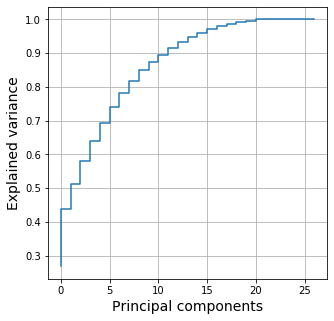

In [28]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.step(range(dataset.shape[1]), pca.explained_variance_ratio_.cumsum())
plt.grid()
plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)

In [29]:
pca.explained_variance_ratio_.cumsum()[20]

0.9964552427175117

In [30]:
dataset = pd.concat((dataset, target_column), axis=1)
correlation_matrix = dataset.corr()

In [31]:
abs(correlation_matrix).style.background_gradient(cmap='coolwarm')

,Age,Credit amount,Duration,Sex_female,Sex_male,Job_0,Job_1,Job_2,Job_3,Housing_free,Housing_own,Housing_rent,Saving accounts_little,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Saving accounts_unk,Checking account_little,Checking account_moderate,Checking account_rich,Purpose_business,Purpose_car,Purpose_education,Purpose_furniture/equipment,Purpose_other,Purpose_radio/TV,Purpose_repairs,Risk
Age,1.000000,0.032716,0.036136,0.161694,0.161694,0.059954,0.043712,0.148283,0.127605,0.253058,0.006553,0.212620,0.044084,0.075302,0.030988,0.032007,0.077811,0.011162,0.078121,0.037504,0.001772,0.099919,0.060390,0.127657,0.021203,0.046401,0.039567,0.091127
Credit amount,0.032716,1.000000,0.624984,0.093482,0.093482,0.027969,0.161757,0.092636,0.319715,0.201643,0.117497,0.024611,0.036443,0.013546,0.064256,0.055542,0.106546,0.020912,0.119612,0.100510,0.103016,0.125575,0.034796,0.034037,0.087952,0.173203,0.028875,0.154739
Duration,0.036136,0.624984,1.000000,0.081432,0.081432,0.044043,0.181203,0.055010,0.147515,0.189117,0.075169,0.064417,0.047228,0.051587,0.040257,0.048261,0.071185,0.022244,0.089452,0.076455,0.164113,0.005320,0.025450,0.062804,0.047883,0.044319,0.022549,0.214927
Sex_female,0.161694,0.093482,0.081432,1.000000,1.000000,0.076356,0.010811,0.007613,0.054070,0.100872,0.119638,0.222845,0.031244,0.000498,0.031414,0.041673,0.043225,0.014834,0.012726,0.004183,0.080875,0.047893,0.052397,0.100467,0.022039,0.008668,0.026828,0.075493
Sex_male,0.161694,0.093482,0.081432,1.000000,1.000000,0.076356,0.010811,0.007613,0.054070,0.100872,0.119638,0.222845,0.031244,0.000498,0.031414,0.041673,0.043225,0.014834,0.012726,0.004183,0.080875,0.047893,0.052397,0.100467,0.022039,0.008668,0.026828,0.075493
Job_0,0.059954,0.027969,0.044043,0.076356,0.076356,1.000000,0.074991,0.195709,0.062511,0.035671,0.040480,0.018886,0.003706,0.050823,0.045288,0.001786,0.017173,0.000428,0.047382,0.073347,0.003087,0.066143,0.008622,0.052801,0.065569,0.063164,0.070459,0.005951
Job_1,0.043712,0.161757,0.181203,0.010811,0.010811,0.074991,1.000000,0.652438,0.208392,0.109543,0.063003,0.014347,0.037811,0.019740,0.006174,0.018712,0.049138,0.023542,0.018041,0.014405,0.005068,0.007405,0.033952,0.020778,0.045737,0.005568,0.044313,0.021822
Job_2,0.148283,0.092636,0.055010,0.007613,0.007613,0.195709,0.652438,1.000000,0.543852,0.033633,0.012866,0.012049,0.058800,0.007564,0.019692,0.055810,0.025230,0.002879,0.067587,0.022932,0.007768,0.097759,0.019075,0.064393,0.055757,0.085802,0.012144,0.013559
Job_3,0.127605,0.319715,0.147515,0.054070,0.054070,0.062511,0.208392,0.543852,1.000000,0.154388,0.071741,0.040344,0.038885,0.011525,0.038527,0.054065,0.013954,0.022427,0.051999,0.015346,0.006128,0.113935,0.008749,0.042335,0.100243,0.096839,0.062511,0.040559
Housing_free,0.253058,0.201643,0.189117,0.100872,0.100872,0.035671,0.109543,0.033633,0.154388,1.000000,0.548445,0.162474,0.012353,0.011914,0.010662,0.047989,0.026964,0.067961,0.000378,0.015860,0.059613,0.126806,0.117976,0.071530,0.029640,0.109357,0.013706,0.081556


In [32]:
input_columns = correlation_matrix.columns.tolist()

In [33]:
correlated_features = {}
for i in range(correlation_matrix.shape[0]):
    correlated_features[input_columns[i]] = {'count' : 0, 'correlated' : []}
    for j in range(correlation_matrix.shape[1]):
        if abs(correlation_matrix.values[i][j]) > 0.5 and abs(correlation_matrix.values[i][j]) < 1:
            correlated_features[input_columns[i]]['count'] = correlated_features[input_columns[i]]['count'] + 1
            correlated_features[input_columns[i]]['correlated'].append(input_columns[j])

In [34]:
filtered = {k: v for k, v in correlated_features.items() if v['count'] >= 2}

In [35]:
filtered

{'Job_2': {'count': 2, 'correlated': ['Job_1', 'Job_3']},
 'Housing_own': {'count': 2, 'correlated': ['Housing_free', 'Housing_rent']}}

In [36]:
dataset = dataset.drop(['Job_2', 'Housing_own'], axis=1)

In [37]:
import fisher_score as fs

In [38]:
scores = fs.fisher_score(dataset.drop('Risk', axis=1).values, dataset['Risk'].values)

In [39]:
ranked = fs.feature_ranking(scores)

In [40]:
importance_ranked_features = dataset.drop('Risk', axis=1).columns[ranked]

In [41]:
print(importance_ranked_features)

Index(['Checking account_little', 'Duration', 'Saving accounts_little',
       'Credit amount', 'Saving accounts_unk', 'Checking account_moderate',
       'Purpose_radio/TV', 'Housing_rent', 'Age', 'Saving accounts_rich',
       'Housing_free', 'Sex_male', 'Sex_female', 'Saving accounts_quite rich',
       'Purpose_education', 'Checking account_rich', 'Job_3',
       'Purpose_business', 'Purpose_other', 'Purpose_car',
       'Saving accounts_moderate', 'Job_1', 'Purpose_furniture/equipment',
       'Purpose_repairs', 'Job_0'],
      dtype='object')


In [42]:
ds_good = dataset[dataset['Risk'] == 1]
ds_bad = dataset[dataset['Risk'] == 0]

In [43]:
ds_bad.shape, ds_good.shape

((300, 26), (700, 26))

In [44]:
ds_train_good = ds_good.sample(n=int(len(ds_bad.index)*0.7))

ds_train_bad = ds_bad.sample(n=int(len(ds_bad.index)*0.7))
ds_train = pd.concat([ds_train_good, ds_train_bad])
print(ds_train.shape)

(420, 26)


In [45]:
ds_test_good = ds_good[~ds_good.isin(ds_train_good)]
ds_test_bad = ds_bad[~ds_bad.isin(ds_train_bad)]

ds_sel = pd.concat([ds_test_good, ds_test_bad]).dropna()

In [46]:
#-----#
X_test = ds_sel.drop('Risk', axis=1)
X_train = ds_train.drop('Risk', axis=1)
#-----#
y_train = ds_train['Risk']
y_test = ds_sel['Risk']

In [47]:
from sklearn.ensemble import RandomForestClassifier

In [48]:
# Declare your model
rf = RandomForestClassifier(n_estimators=300, class_weight = 'balanced')

In [49]:
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

In [50]:
confusion_matrix(y_test, y_pred)

array([[ 60,  30],
       [137, 353]], dtype=int64)

In [51]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.30      0.67      0.42        90
         1.0       0.92      0.72      0.81       490

    accuracy                           0.71       580
   macro avg       0.61      0.69      0.61       580
weighted avg       0.83      0.71      0.75       580



In [52]:
accuracy_score(y_test,y_pred)

0.7120689655172414

### Evaluation

In [80]:
# importances = {}
# importances['importances'] = rf.feature_importances_
importances = rf.feature_importances_

In [54]:
import scoring

import importlib as im
im.reload(scoring)

<module 'scoring' from 'C:\\Users\\USER\\ai\\Data Science\\scoring.py'>

In [55]:
features_names = np.array(X_train.columns.tolist())

Feature ranking:


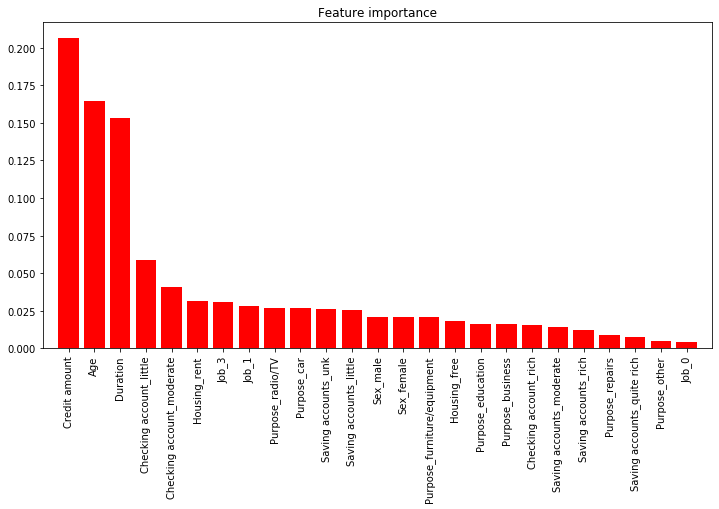

In [56]:
scoring.plot_feature_importance(
    rf.feature_importances_, 
                                features_names, 
                                thresh = None, 
                                title = None, 
                                figsize = None)

In [81]:
result = {}
for c in [0,1]:
    result[c] = np.mean(dataset[dataset["Risk"]==c],axis=0).drop("Risk")*importances
    
    

In [79]:
np.mean(dataset[dataset['Risk']==c], axis=0).drop('Risk') * importances['importances']

Age                           -0.022877
Credit amount                  0.048827
Duration                       0.050205
Sex_female                     0.007584
Sex_male                       0.013491
Job_0                          0.000095
Job_1                          0.005309
Job_3                          0.005203
Housing_free                   0.002707
Housing_rent                   0.007293
Saving accounts_little         0.018287
Saving accounts_moderate       0.001644
Saving accounts_quite rich     0.000289
Saving accounts_rich           0.000240
Saving accounts_unk            0.002774
Checking account_little        0.026563
Checking account_moderate      0.014300
Checking account_rich          0.000713
Purpose_business               0.001830
Purpose_car                    0.009404
Purpose_education              0.001269
Purpose_furniture/equipment    0.003977
Purpose_other                  0.000145
Purpose_radio/TV               0.005503
Purpose_repairs                0.000242


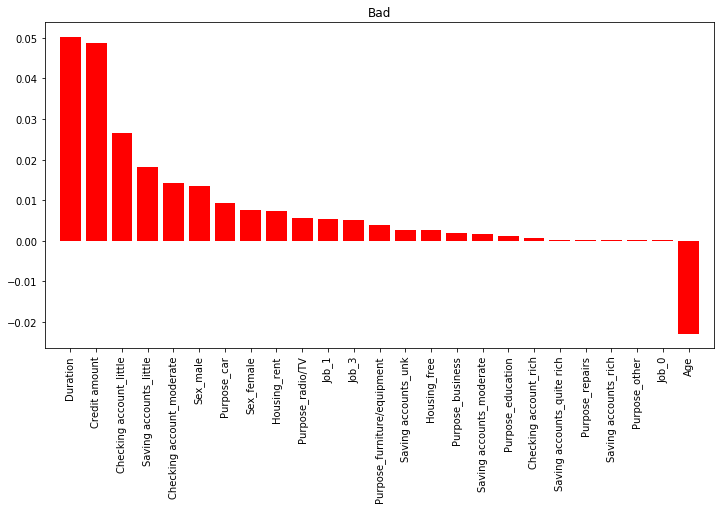

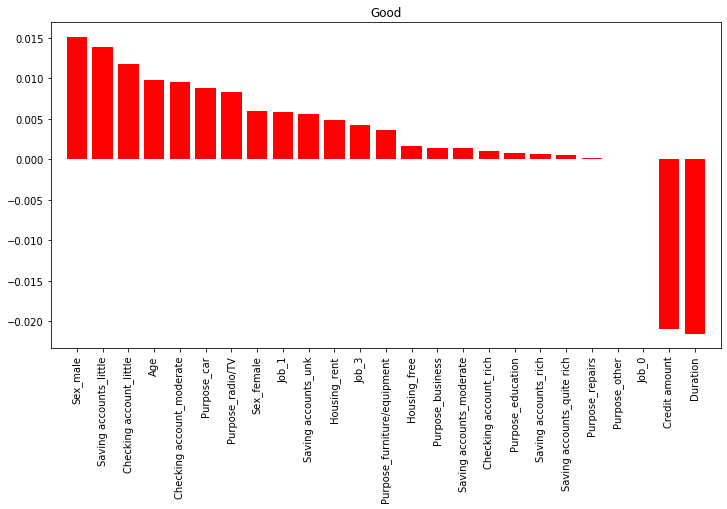

In [82]:
scoring.plot_class_feature_importance(features_names, 
                                      result, 
                                      class_names = ['Bad', 'Good'])